In [54]:
import os
import math

import netCDF4
import numpy as np
import pandas
import folium

import pyart

from matplotlib import pyplot as plt
import pyproj

import folium
from folium import IFrame
from folium.plugins import Draw
from folium.plugins import MeasureControl
from folium.plugins import FloatImage


In [28]:
sites_ffn   = 'dwd_siteinfo_current.txt'
image_ffn   = 'overlap.png'
radar_dist_threshold = 300000 #m
overlap_dist_threshold = 150000 #m
min_angle = math.radians(30) #deg
max_angle = math.radians(150) #deg
max_overlap_count = 3

lat_0   = 51.023   #grid centre lat
lon_0   = 10.098   #grid centre lon
grid_range = 500000.  #m
grid_space = 1000.    #m
R       = 6370997. #m, earth radius

In [27]:
#taken directly from folium 0.6.0 source as was not included in conda-forge build

#-*- coding: utf-8 -*-

from __future__ import (absolute_import, division, print_function)

import json

from branca.element import CssLink, Figure, JavascriptLink, MacroElement

from jinja2 import Template


class MousePosition(MacroElement):
    """Add a field that shows the coordinates of the mouse position.
    Uses the Leaflet plugin by Ardhi Lukianto under MIT license.
    https://github.com/ardhi/Leaflet.MousePosition
    Parameters
    ----------
    position : str, default 'bottomright'
        The standard Control position parameter for the widget.
    separator : str, default ' : '
        Character used to separate latitude and longitude values.
    empty_string : str, default 'Unavailable'
       Initial text to display.
    lng_first : bool, default False
        Whether to put the longitude first or not.
        Set as True to display longitude before latitude.
    num_digits : int, default '5'
        Number of decimal places included in the displayed
        longitude and latitude decimal degree values.
    prefix : str, default ''
        A string to be prepended to the coordinates.
    lat_formatter : str, default None
        Custom Javascript function to format the latitude value.
    lng_formatter : str, default None
        Custom Javascript function to format the longitude value.
    Examples
    --------
    >>> fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
    >>> MousePosition(position='topright', separator=' | ', prefix="Mouse:",
    ...               lat_formatter=fmtr, lng_formatter=fmtr)
    """
    _template = Template("""
        {% macro script(this, kwargs) %}
        var {{ this.get_name() }} = new L.Control.MousePosition(
            {{ this.options }});
        {{ this.get_name() }}.options["latFormatter"] = {{ this.lat_formatter }};
        {{ this.get_name() }}.options["lngFormatter"] = {{ this.lng_formatter }};
        {{ this._parent.get_name() }}.addControl({{ this.get_name() }});
        {% endmacro %}
    """)  # noqa

    def __init__(self, position='bottomright', separator=' : ',
                 empty_string='Unavailable', lng_first=False, num_digits=5,
                 prefix='', lat_formatter=None, lng_formatter=None):

        super(MousePosition, self).__init__()
        self._name = 'MousePosition'

        options = {
            'position': position,
            'separator': separator,
            'emptyString': empty_string,
            'lngFirst': lng_first,
            'numDigits': num_digits,
            'prefix': prefix,
        }
        self.options = json.dumps(options, sort_keys=True, indent=2)
        self.lat_formatter = lat_formatter or 'undefined'
        self.lng_formatter = lng_formatter or 'undefined'

    def render(self, **kwargs):
        super(MousePosition, self).render()

        figure = self.get_root()
        assert isinstance(figure, Figure), ('You cannot render this Element '
                                            'if it is not in a Figure.')

        figure.header.add_child(JavascriptLink('https://cdn.rawgit.com/ardhi/Leaflet.MousePosition/c32f1c84/src/L.Control.MousePosition.js'))  # noqa

        figure.header.add_child(CssLink('https://cdn.rawgit.com/ardhi/Leaflet.MousePosition/c32f1c84/src/L.Control.MousePosition.css'))  # noqa


In [4]:
def read_csv(csv_ffn, header_line):
    """
    CSV reader used for the radar locations file (comma delimited)
    
    Parameters:
    ===========
        csv_ffn: str
            Full filename to csv file
            
        header_line: int or None
            to use first line of csv as header = 0, use None to use column index
            
    Returns:
    ========
        as_dict: dict
            csv columns are dictionary
    
    """
    df = pandas.read_csv(csv_ffn, header=header_line, skipinitialspace=True)
    as_dict = df.to_dict(orient='list')
    return as_dict

def get_distance(lat_1, lng_1, lat_2, lng_2, R): 
    
    s_lat = lat_1*np.pi/180.0                      
    s_lng = np.deg2rad(lng_1)     
    e_lat = np.deg2rad(lat_2)                       
    e_lng = np.deg2rad(lng_2)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d)) 

def get_bca(rad1_lon, rad1_lat, rad2_lon, rad2_lat, x, y, projparams):
    """
    This function gets the beam crossing angle between two lat/lon pairs.
    Parameters
    ==========
    rad1_lon: float
        The longitude of the first radar.
    rad1_lat: float
        The latitude of the first radar.
    rad2_lon: float
        The longitude of the second radar.
    rad2_lat: float
        The latitude of the second radar.
    x: nD float array
        The Cartesian x coordinates of the grid
    y: nD float array
        The Cartesian y corrdinates of the grid
    projparams: Py-ART projparams
        The projection parameters of the Grid
    Returns
    =======
    bca: nD float array
        The beam crossing angle between the two radars in radians.
    """

    rad1 = pyart.core.geographic_to_cartesian(rad1_lon, rad1_lat, projparams)
    rad2 = pyart.core.geographic_to_cartesian(rad2_lon, rad2_lat, projparams)
    # Create grid with Radar 1 in center

    x = x-rad1[0]
    y = y-rad1[1]
    rad2 = np.array(rad2) - np.array(rad1)
    a = np.sqrt(np.multiply(x, x) + np.multiply(y, y))
    b = np.sqrt(pow(x-rad2[0], 2) + pow(y-rad2[1], 2))
    c = np.sqrt(rad2[0]*rad2[0] + rad2[1]*rad2[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-rad2[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))


In [104]:
#create lat lon grid using transverse mercator projection on WGS84 elliposid (pyart aedp cannot be used)
projection_input = " ".join(["+proj=tmerc",
                              "+lon_0="+str(lon_0),
                              "+lat_0="+str(lat_0),
                              "+k=1 +x_0=0 +y_0=0",
                              "+ellps=WGS84 +datum=WGS84 +units=m",
                              "+no_defs"])

x_vec = np.arange(-grid_range, grid_range+grid_space, grid_space)
y_vec = np.arange(-grid_range, grid_range+grid_space, grid_space)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

#transform
proj = pyproj.Proj(projection_input)
lon_grid, lat_grid = proj(x_grid, y_grid, inverse=True)

#calculate bounds
max_lat = np.max(lat_grid)
min_lat = np.min(lat_grid)
max_lon = np.max(lon_grid)
min_lon = np.min(lon_grid)
bounds = [[min_lat, min_lon], [max_lat, max_lon]]


[[46.34196310421985, 2.224816365421059], [55.51571919232244, 17.971183634578942]]


In [105]:
#read site info
site_dict = read_csv(sites_ffn, 0)
site_lat = site_dict['lat']
site_lon = site_dict['lon']
site_id  = site_dict['id']
lobe_list = []

#calculate lobe pairs
for i,_ in enumerate(site_id):
    for j,_ in enumerate(site_id):
        #skip same radar
        if i==j:
            continue
        #skip processed radars
        if [i,j] in lobe_list or [j,i] in lobe_list:
            continue
        #calc distance
        radar_dist = get_distance(site_lat[i], site_lon[i], site_lat[j], site_lon[j], R)
        if radar_dist <= radar_dist_threshold:
            lobe_list.append([i,j])
print(lobe_list)

[[0, 1], [0, 4], [0, 6], [0, 7], [0, 18], [1, 7], [1, 13], [1, 14], [1, 16], [2, 3], [2, 10], [2, 13], [2, 16], [3, 8], [3, 9], [3, 10], [3, 12], [3, 15], [4, 6], [4, 7], [4, 11], [4, 12], [4, 17], [4, 18], [5, 9], [5, 11], [5, 12], [5, 15], [6, 7], [6, 10], [6, 11], [6, 12], [6, 16], [6, 17], [6, 18], [7, 10], [7, 12], [7, 13], [7, 14], [7, 16], [7, 17], [7, 18], [8, 9], [8, 10], [8, 15], [9, 10], [9, 12], [9, 15], [10, 12], [10, 15], [10, 16], [10, 17], [11, 12], [11, 15], [11, 17], [11, 18], [12, 15], [12, 16], [12, 17], [12, 18], [13, 14], [13, 16], [14, 16], [17, 18]]


In [106]:
overlap_grid = np.zeros_like(x_grid)

for lobe_pair in lobe_list:
    #extract pair coordinates
    rad1_lat = site_lat[lobe_pair[0]]
    rad1_lon = site_lon[lobe_pair[0]]
    rad2_lat = site_lat[lobe_pair[1]]
    rad2_lon = site_lon[lobe_pair[1]]
    
    #calculate ray angle
    ray_angle   = get_bca(rad1_lon, rad1_lat, rad2_lon, rad2_lat, x_grid, y_grid, projparams)
    #calculate distance from radars
    radar1_dist = get_distance(rad1_lat, rad1_lon, lat_grid, lon_grid, R)
    radar2_dist = get_distance(rad2_lat, rad2_lon, lat_grid, lon_grid, R)
    #threshold dist, angle and combine
    dist_mask = np.logical_and(radar1_dist<=overlap_dist_threshold, radar2_dist<=overlap_dist_threshold)
    ang_mask  = np.logical_and(ray_angle>=min_angle, ray_angle<+max_angle)
    combine_mask = np.logical_and(dist_mask, ang_mask)
    #add  to overlap
    overlap_grid = overlap_grid + combine_mask

/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/meso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encoun

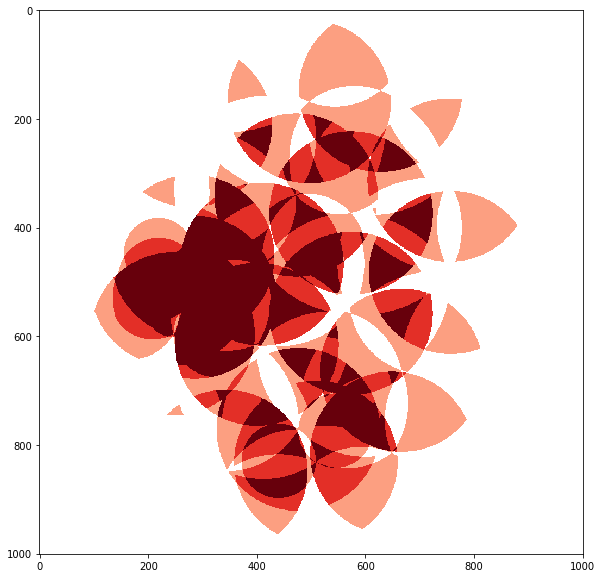

In [107]:
#apply max overlap
overlap_grid[overlap_grid>max_overlap_count] = max_overlap_count

#flipud
overlap_grid = np.flipud(overlap_grid)

#add transparent layer
overlap_grid[overlap_grid==0] = np.nan
fig = plt.figure(facecolor='white', figsize=(10, 10))
plt.imshow(overlap_grid, 'Reds', vmin=0, vmax=max_overlap_count)

plt.imsave(image_ffn, overlap_grid, cmap='Reds', vmin=0, vmax=max_overlap_count)


In [116]:
#create leaflet file import folium

# build mapbox url for leaflet
# https://docs.mapbox.com/studio-manual/overview/publish-your-style/
mapbox_un = 'jss432'
mapbox_styleid = 'cjvjovyjv0nvu1csap9l5aaqv'
mapbox_token = 'pk.eyJ1IjoianNzNDMyIiwiYSI6ImNqbXZpYnB6djA1YWozcG13azNtOGx4cjgifQ.ti9LEeP0RI-e7tf2mohr-A'
url = 'https://api.mapbox.com/styles/v1/' + mapbox_un + '/' + mapbox_styleid + '/tiles/256/{z}/{x}/{y}?access_token=' + mapbox_token

#init map
m = folium.Map(location=[lat_0, lon_0],
           zoom_start=6,
           tiles=url,
           attr='mapbox')

#add controls
draw = Draw(export=True)
draw.add_to(m)
m.add_child(MeasureControl())
m.add_child(MousePosition())

#add overlay to map
#NEED TO FIX!!!!!!!!!!!!!!!!
#
bounds = [[min_lat, min_lon+0.3], [max_lat, max_lon-0.3]]
folium.raster_layers.ImageOverlay(
        image=image_ffn,
        bounds=bounds,
        origin='lower',
        opacity=0.4
    ).add_to(m)

#save to file
m.save(outfile = 'germany_overlap.html')


#add radar markers
#upload to S3